In [1]:
from __future__ import print_function, division
import os,sys
import numpy as np
import torch # pytorch package, allows using GPUs
# fix seed
seed=17
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import datasets # load data
from torch.nn.utils.rnn import pad_sequence

all_data = 'ExpL project/MPSEQCN1.csv'
#all_data = 'ExpL project/MP_W_Seq.csv'
# Mapping for mechanical properties (assuming CSV columns [11,13,15,17] in this order)
target_property_index = {
    'toughness': 0,
    'youngs_modulus': 1,
    'tensile_strength': 2,
    'strain_at_break': 3
}
# Mapping: assign unique numbers (1-20) based on polarity order (least polar → most polar)
aa_to_polarity = {
    'L': 1,  # Leucine
    'F': 2,  # Phenylalanine
    'I': 3,  # Isoleucine
    'C': 4,  # Cysteine
    'M': 5,  # Methionine
    'V': 6,  # Valine
    'W': 7,  # Tryptophan
    'Y': 8,  # Tyrosine
    'P': 9,  # Proline
    'A': 10, # Alanine
    'T': 11, # Threonine
    'G': 12, # Glycine
    'S': 13, # Serine
    'H': 14, # Histidine
    'Q': 15, # Glutamine
    'R': 16, # Arginine
    'K': 17, # Lysine
    'N': 18, # Asparagine
    'E': 19, # Glutamic acid
    'D': 20  # Aspartic acid
}
# Reverse mapping to decode numbers back into amino acids.
polarity_to_aa = {v: k for k, v in aa_to_polarity.items()}
def sequence_to_polarity_numbers(seq, mapping=aa_to_polarity):
    """
    Convert an amino acid sequence to a list of unique integer values based on polarity.
    Amino acids not in the mapping will be assigned 0.
    """
    return [mapping.get(aa, 0) for aa in seq]

In [3]:
import argparse
import sys; sys.argv=['']; del sys  # for Jupyter notebooks

parser = argparse.ArgumentParser(
    description='PyTorch Regression Model: Predict a Mechanical Property from AA Sequences')
# ... (other arguments)
parser.add_argument('--target-property', type=str, choices=['toughness', 'youngs_modulus', 'tensile_strength', 'strain_at_break'],
                    default='youngs_modulus', help='Mechanical property to predict')
# example values for other arguments:
parser.add_argument('--batch-size', type=int, default=32, metavar='N', help='Training batch size (default: 32)')
parser.add_argument('--test-batch-size', type=int, default=64, metavar='N', help='Test batch size (default: 64)')
parser.add_argument('--epochs', type=int, default=5, metavar='N', help='Number of epochs (default: 5)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR', help='Learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M', help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False, help='Disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S', help='Random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=1, metavar='N', help='Batches between logging (default: 1)')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
print("Arguments:", args)


Arguments: Namespace(target_property='youngs_modulus', batch_size=32, test_batch_size=64, epochs=5, lr=0.01, momentum=0.5, no_cuda=False, seed=1, log_interval=1, cuda=False)


In [4]:
class Silkome_Dataset(Dataset):
    """Silkome pytorch dataset for the mechanical properties and amino acid sequences.
     Assumes:
      - uses a CSV file where:
          - index 0: Individual IDs.
          - indexes 11, 13, 15, 17: Mechanical properties 
            (in order: "toughness", "youngs_modulus", "tensile_strength", "strain_at_break").
          - index 21: Amino acid sequences concatenated from two columns.
            (Sequences are assumed to be separated by a comma ',')
      - Each cell in the sequence column must contain at least one sequence.
      - Maximum number of sequences per cell is 2.
      - Each sequence must have a length between 151 and 1515.
    """

    def __init__(self, all_data, data_type='train', transform=None, test_size=0.2, random_state=42):
        """
       Args:
            all_data (str): Path to the CSV file. (ExpL project/MP_W_Seq.csv)
            data_type (str): 'train' or 'test'. Use 'train' for the training set and 'test' for the testing set.
            transform (callable, optional): Optional transform to be applied on a sample.
            test_size (float): Fraction of data to use as test set.
            random_state (int): Seed for splitting.
        """
        self.df = pd.read_csv(all_data)
        
        # Extract individual IDs from column 0
        self.ids = self.df.iloc[:, 0].values

        # Extract mechanical properties from columns 11, 13, 15, 17
        self.mechanical_props = self.df.iloc[:, [11, 13, 15, 17]].values.astype(np.float32)

        # Process the amino acid sequences from column 21.
        # First, fill missing values (if any) with an empty string.
        raw_sequences = self.df["MaSp1"].fillna('').values

        processed_sequences = []
        polarity_numeric_sequences = []  # Store numeric representations based on polarity.
        for i, s in enumerate(raw_sequences):
            # Split on comma; adjust the delimiter if needed.
            seq_list = [seq.strip() for seq in s.split(',') if seq.strip() != '']
            
            # Filter each sequence by length (151 to 1515 AAs)
            valid_seqs = [seq for seq in seq_list if 151 <= len(seq) <= 1515]
            #print (valid_seqs)
            
            processed_sequences.append(valid_seqs)
            
            # Convert each valid sequence to its numeric representation based on polarity.
            numeric_seq_list = [sequence_to_polarity_numbers(seq) for seq in valid_seqs]
            polarity_numeric_sequences.append(numeric_seq_list)
        #print("Length of IDs:", len(self.ids))
        #print("Length of processed sequences:", len(processed_sequences))
        #print("DataFrame shape:", self.df.shape)
        #print("Columns:", self.df.columns)
        #print("Raw sequences array length:", len(raw_sequences))
        #print("First few raw sequences:", raw_sequences[:5])

        
        self.sequences = processed_sequences
        self.polarity_numeric_sequences = polarity_numeric_sequences
        
        #train/test split
        if data_type in ['train', 'test']:
            indices = np.arange(len(self.ids))
            train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)
            if data_type == 'train':
                sel = train_idx
                print("Using training set (80% of data)")
            else:
                sel = test_idx
                print("Using testing set (20% of data)")
            
            self.ids = self.ids[sel]
            self.mechanical_props = self.mechanical_props[sel]
            self.sequences = [self.sequences[i] for i in sel]
            self.polarity_numeric_sequences = [self.polarity_numeric_sequences[i] for i in sel]
        
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        sample = {
            'id': self.ids[idx],
            'mechanical_props': self.mechanical_props[idx],  # ex, a numpy array of shape (4,)
            #'sequences': self.sequences[idx],  # list of one to eight sequences (strings)
            'polarity_numeric_sequences': self.polarity_numeric_sequences[idx]
        }
        if self.transform:
            sample = self.transform(sample)
        return sample

def custom_collate(batch):
    """
    Converts a batch from the dataset (with keys:
      - 'id'
      - 'mechanical_props': vector of 4 values per sample
      - 'polarity_numeric_sequences': list of sequences (each a list of ints)
    )
    into a dictionary with keys:
      - 'sequence': a padded LongTensor of shape (batch, max_len) using the first sequence.
      - 'mechanical_input': auxiliary mechanical input (can be chosen as needed).
      - 'target': the chosen mechanical property to predict.
    """
    import torch
    batch_ids = [item['id'] for item in batch]
    batch_mech = torch.stack([torch.tensor(item['mechanical_props']) for item in batch])
    
    # Select the target property using the index from mapping.
    target_idx = target_property_index[args.target_property]
    batch_target = batch_mech[:, target_idx].unsqueeze(1)
    
    # For the sequence, take the first available numeric sequence from each sample.
    batch_sequence = [
        item['polarity_numeric_sequences'][0] if len(item['polarity_numeric_sequences']) > 0 else []
        for item in batch
    ]
    
    max_len = 200  # Fixed padded sequence length.
    padded_sequences = []
    for seq in batch_sequence:
        seq_tensor = torch.tensor(seq, dtype=torch.long)
        if seq_tensor.numel() < max_len:
            pad = torch.zeros(max_len - seq_tensor.numel(), dtype=torch.long)
            padded_seq = torch.cat([seq_tensor, pad])
        else:
            padded_seq = seq_tensor[:max_len]
        padded_sequences.append(padded_seq)
    batch_sequence_tensor = torch.stack(padded_sequences)  # shape: (batch, max_len)
    
    auxiliary_idx = 1  #PROP TO PREDICT
    batch_mechanical_input = batch_mech[:, auxiliary_idx].unsqueeze(1)  # shape: (batch, 1)
    
    return {
        'id': batch_ids,
        'sequence': batch_sequence_tensor,
        'mechanical_input': batch_mechanical_input,
        'target': batch_target
    }


def load_data(all_data, batch_size, test_batch_size, **kwargs):
    """
    Create PyTorch DataLoaders for training and testing from the CSV file.
    
    Args:
        all_data (str): Path to the CSV file.
        batch_size (int): Batch size for the training loader.
        test_batch_size (int): Batch size for the test loader.
        **kwargs: Additional arguments for DataLoader (e.g., num_workers, pin_memory).
    
    Returns:
        train_loader, test_loader: DataLoader objects.
    """
    train_dataset = Silkome_Dataset(all_data=all_data, data_type='train')
    test_dataset = Silkome_Dataset(all_data=all_data, data_type='test')
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              collate_fn=custom_collate, **kwargs)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, 
                             collate_fn=custom_collate, **kwargs)

    
    return train_loader, test_loader

# Example usage:
if __name__ == "__main__":
    csv_path = 'ExpL project/MPSEQCN1.csv'
    train_loader, test_loader = load_data(csv_path, batch_size=32, test_batch_size=32)
    
    # Iterate through one batch from the training loader and print a sample
    for batch in train_loader:
        print("IDs:", batch['id'])
        print("Mechanical properties:", batch['mechanical_input'])
        print("Sequences:", batch['sequence'])
        break

Using training set (80% of data)
Using testing set (20% of data)
IDs: [6019, 3883, 4007, 7303, 5239, 5104, 6713, 2801, 2156, 6755, 4910, 5337, 5804, 6748, 3899, 3393, 1894, 3819, 5118, 2664, 6329, 2158, 6266, 4542, 5219, 5457, 3469, 5290, 7302, 6795, 5249, 3793]
Mechanical properties: tensor([[10.7000],
        [15.4000],
        [ 6.1900],
        [ 8.7800],
        [ 5.4100],
        [ 2.3800],
        [13.7000],
        [13.7000],
        [12.3000],
        [ 7.8100],
        [ 7.1300],
        [ 1.9000],
        [10.5000],
        [ 7.8900],
        [ 4.2300],
        [ 8.6100],
        [ 9.6000],
        [ 7.9300],
        [ 2.5700],
        [16.6000],
        [ 8.6200],
        [ 9.5100],
        [ 6.3100],
        [ 5.6300],
        [ 3.2300],
        [ 2.1900],
        [ 3.2600],
        [15.1000],
        [13.1000],
        [17.3000],
        [13.0000],
        [19.0000]])
Sequences: tensor([[15, 12, 12,  ..., 15, 12, 12],
        [10, 10, 10,  ..., 12, 13, 12],
        [ 5, 1

Defining the Neural Network and its Architecture

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vocab_size=21, embedding_dim=32, max_len=200, 
                 conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64):
        """
        Args:
            vocab_size (int): Number of unique tokens (e.g. 21 if you map AAs 1-20, 0 for padding).
            embedding_dim (int): Dimension of the embedding vectors.
            max_len (int): Fixed length for padded amino acid sequences.
            conv_out_channels (int): Number of output channels for the 1D convolution.
            hidden_dim_seq (int): Size of the intermediate representation from the sequence branch.
            hidden_dim_combined (int): Size of the combined hidden layer.
            
        The model processes a padded, numeric sequence (shape: [batch, max_len]) and 
        a mechanical property input (shape: [batch, 1]) and outputs a single continuous prediction.
        """
        super(Model, self).__init__()
        # Embedding layer to convert token indices to embeddings.
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        # 1D Convolution over the sequence dimension.
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=conv_out_channels,
                               kernel_size=3, padding=1)
        # 1D max pooling to reduce sequence length.
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the pooled sequence length.
        pooled_len = max_len // 2  # This assumes max_len is even.
        
        # Fully connected layer to obtain a fixed-length representation from the sequence.
        self.fc_seq = nn.Linear(conv_out_channels * pooled_len, hidden_dim_seq)
        
        # Fully connected layer to combine the sequence representation and mechanical input.
        self.fc_combined = nn.Linear(hidden_dim_seq + 1, hidden_dim_combined)
        
        # Output layer: predict one continuous value (the target mechanical property).
        self.fc_out = nn.Linear(hidden_dim_combined, 1)
        
    def forward(self, sample):
        """
        Args:
            sample (dict): Should contain:
                - 'sequence': Long tensor of shape (batch, max_len) containing the padded, numerically encoded sequence.
                - 'mechanical_input': Tensor of shape (batch, 1) with the extra mechanical property.
                
        Returns:
            Tensor of shape (batch, 1) with the predicted continuous value.
        """
        # Extract inputs.
        seq = sample['sequence']           # shape: (batch, max_len)
        mech = sample['mechanical_input']  # shape: (batch, 1)
        
        # Process the sequence.
        # Embedding: (batch, max_len) --> (batch, max_len, embedding_dim)
        x = self.embedding(seq)
        # Permute to shape: (batch, embedding_dim, max_len) for convolution.
        x = x.permute(0, 2, 1)
        # Convolution and ReLU activation.
        x = F.relu(self.conv1(x))
        # Max pooling reduces the sequence length.
        x = self.pool(x)  # shape: (batch, conv_out_channels, max_len//2)
        # Flatten the convolution output.
        x = x.view(x.size(0), -1)
        # Fully connected layer to obtain sequence representation.
        x_seq = F.relu(self.fc_seq(x))
        
        # Concatenate the sequence representation with the mechanical property.
        x_comb = torch.cat([x_seq, mech], dim=1)
        x_comb = F.relu(self.fc_combined(x_comb))
        output = self.fc_out(x_comb)
        return output

# Example usage:
if __name__ == "__main__":
    # Instantiate the model.
    # Here we use a smaller max_len for demonstration purposes.
    model = Model(vocab_size=21, embedding_dim=32, max_len=200, 
                  conv_out_channels=64, hidden_dim_seq=128, hidden_dim_combined=64)
    
    # Dummy input:
    # Create a dummy batch of 32 sequences, each padded to length 200.
    dummy_sequence = torch.randint(0, 21, (32, 200))
    # Create a dummy batch of 32 mechanical input values.
    dummy_mechanical = torch.randn(32, 1)
    
    dummy_input = {'sequence': dummy_sequence, 'mechanical_input': dummy_mechanical}
    
    # Get predictions.
    predictions = model(dummy_input)
    print("Predictions shape:", predictions.shape)  # Expected shape: (32, 1)


Predictions shape: torch.Size([32, 1])


In [6]:
from tqdm import tqdm
def train(epoch):
    model.train()  # Set model to training mode (affects Dropout, BatchNorm, etc.)
    for batch_idx, sample in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Move each tensor in the sample dictionary to GPU if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        
        optimizer.zero_grad()
        output = model(sample)  # The model expects a dictionary input.
        
        # Compute the mean squared error between predictions and target values.
        loss = F.mse_loss(output, sample['target'])
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            # Here, sample['target'] is assumed to be of shape (batch_size, 1)
            processed = batch_idx * sample['target'].size(0)
            total = len(train_loader.dataset)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, processed, total,
                100. * batch_idx / len(train_loader), loss.item()))

def test(data_loader, verbose='Test'):
    model.eval()  # Set model to evaluation mode.
    test_loss = 0
    with torch.no_grad():
        for sample in data_loader:
            if args.cuda:
                sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                          for key, value in sample.items()}
            output = model(sample)
            # Sum the MSE loss over the batch.
            test_loss += F.mse_loss(output, sample['target'], reduction='sum').item()
    
    test_loss /= len(data_loader.dataset)
    print('\n{} set: Average loss: {:.4f}\n'.format(verbose, test_loss))
    return test_loss


In [7]:
import torch.nn.functional as F
import torch.optim as optim

# load data using your load_data function (which already applies custom_collate)
train_loader, test_loader = load_data(all_data, batch_size=args.batch_size, test_batch_size=args.test_batch_size)

test_array = []
critical_array = []  # if you have a critical_loader defined

# We will vary the convolutional layer's depth (conv_out_channels) with values from N_array.
N_array = [1, 5, 10, 20, 50]

for N in N_array:
    # Instantiate the regression model.
    # Here, max_len is the fixed padded length for your sequence,
    # vocab_size=21 assumes tokens 1-20 for amino acids (0 used for padding).
    model = Model(vocab_size=21, embedding_dim=32, max_len=200, 
                  conv_out_channels=N, hidden_dim_seq=128, hidden_dim_combined=64)
    if args.cuda:
        model = model.cuda()

    # For regression, we'll use MSE loss inside the train/test functions.
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    # Train the model for a fixed number of epochs.
    for epoch in range(1, args.epochs + 1):
        train(epoch)  # Your train() function should use `model` and `optimizer`
        
        # At the final epoch, store the test losses.
        if epoch == args.epochs:
            test_loss = test(test_loader, verbose='Test')
            test_array.append(test_loss)
    
    print("For conv_out_channels =", N)
    print("Test losses:", test_array)

Using training set (80% of data)
Using testing set (20% of data)


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 61.06it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 88.052391
Train Epoch: 1 [32/140 (20%)]	Loss: 20.991468
Train Epoch: 1 [64/140 (40%)]	Loss: 294.088318
Train Epoch: 1 [96/140 (60%)]	Loss: 68.049156
Train Epoch: 1 [48/140 (80%)]	Loss: 125.560738



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 92.388855
Train Epoch: 2 [32/140 (20%)]	Loss: 60.882622
Train Epoch: 2 [64/140 (40%)]	Loss: 68.049500
Train Epoch: 2 [96/140 (60%)]	Loss: 30.655926


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 72.41it/s]


Train Epoch: 2 [48/140 (80%)]	Loss: 235.380249


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 82.077637
Train Epoch: 3 [32/140 (20%)]	Loss: 62.040787
Train Epoch: 3 [64/140 (40%)]	Loss: 56.961956
Train Epoch: 3 [96/140 (60%)]	Loss: 85.899551


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 63.81it/s]


Train Epoch: 3 [48/140 (80%)]	Loss: 40.219074


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 72.434143
Train Epoch: 4 [32/140 (20%)]	Loss: 43.567032
Train Epoch: 4 [64/140 (40%)]	Loss: 43.548775
Train Epoch: 4 [96/140 (60%)]	Loss: 62.756756


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 75.49it/s]


Train Epoch: 4 [48/140 (80%)]	Loss: 38.165714


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 50.216034
Train Epoch: 5 [32/140 (20%)]	Loss: 46.460629
Train Epoch: 5 [64/140 (40%)]	Loss: 44.472706


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 74.56it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 33.024963
Train Epoch: 5 [48/140 (80%)]	Loss: 25.002832

Test set: Average loss: 45.3521

For conv_out_channels = 1
Test losses: [45.35205078125]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 105.155670
Train Epoch: 1 [32/140 (20%)]	Loss: 29.177738
Train Epoch: 1 [64/140 (40%)]	Loss: 410.232788


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 60.52it/s]


Train Epoch: 1 [96/140 (60%)]	Loss: 76.163460
Train Epoch: 1 [48/140 (80%)]	Loss: 80.863869


Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 53.823753


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 66.66it/s]

Train Epoch: 2 [32/140 (20%)]	Loss: 257.157440
Train Epoch: 2 [64/140 (40%)]	Loss: 58.178459
Train Epoch: 2 [96/140 (60%)]	Loss: 45.880669
Train Epoch: 2 [48/140 (80%)]	Loss: 67.496605



Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 73.342850
Train Epoch: 3 [32/140 (20%)]	Loss: 74.807159
Train Epoch: 3 [64/140 (40%)]	Loss: 113.510445


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 72.09it/s]


Train Epoch: 3 [96/140 (60%)]	Loss: 54.617435
Train Epoch: 3 [48/140 (80%)]	Loss: 59.128124


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 86.067055
Train Epoch: 4 [32/140 (20%)]	Loss: 44.676384
Train Epoch: 4 [64/140 (40%)]	Loss: 43.834602
Train Epoch: 4 [96/140 (60%)]	Loss: 60.338024


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 61.40it/s]


Train Epoch: 4 [48/140 (80%)]	Loss: 61.334095


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 36.854721
Train Epoch: 5 [32/140 (20%)]	Loss: 40.545166
Train Epoch: 5 [64/140 (40%)]	Loss: 63.482868


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 67.16it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 37.040451
Train Epoch: 5 [48/140 (80%)]	Loss: 47.448914

Test set: Average loss: 47.1418

For conv_out_channels = 5
Test losses: [45.35205078125, 47.14183213975694]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 70.942406
Train Epoch: 1 [32/140 (20%)]	Loss: 36.695034


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 59.86it/s]

Train Epoch: 1 [64/140 (40%)]	Loss: 252.456131
Train Epoch: 1 [96/140 (60%)]	Loss: 106.230759
Train Epoch: 1 [48/140 (80%)]	Loss: 99.229164



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 73.707703


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 62.15it/s]

Train Epoch: 2 [32/140 (20%)]	Loss: 110.811157
Train Epoch: 2 [64/140 (40%)]	Loss: 89.180252
Train Epoch: 2 [96/140 (60%)]	Loss: 49.642433
Train Epoch: 2 [48/140 (80%)]	Loss: 49.554783



Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 60.785004
Train Epoch: 3 [32/140 (20%)]	Loss: 47.017155
Train Epoch: 3 [64/140 (40%)]	Loss: 70.863182
Train Epoch: 3 [96/140 (60%)]	Loss: 59.070572


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 60.83it/s]


Train Epoch: 3 [48/140 (80%)]	Loss: 43.555676


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 69.295433
Train Epoch: 4 [32/140 (20%)]	Loss: 54.868324
Train Epoch: 4 [64/140 (40%)]	Loss: 26.312605


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 57.91it/s]


Train Epoch: 4 [96/140 (60%)]	Loss: 32.846836
Train Epoch: 4 [48/140 (80%)]	Loss: 30.829857


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 30.673002
Train Epoch: 5 [32/140 (20%)]	Loss: 43.292442


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 62.99it/s]

Train Epoch: 5 [64/140 (40%)]	Loss: 27.411556
Train Epoch: 5 [96/140 (60%)]	Loss: 46.246342
Train Epoch: 5 [48/140 (80%)]	Loss: 20.109369

Test set: Average loss: 41.0179



For conv_out_channels = 10
Test losses: [45.35205078125, 47.14183213975694, 41.017920600043404]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 104.188354
Train Epoch: 1 [32/140 (20%)]	Loss: 28.849100
Train Epoch: 1 [64/140 (40%)]	Loss: 1096.981934
Train Epoch: 1 [96/140 (60%)]	Loss: 193.219910


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 54.03it/s]

Train Epoch: 1 [48/140 (80%)]	Loss: 16.530684



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 2837.849365
Train Epoch: 2 [32/140 (20%)]	Loss: 193.410522
Train Epoch: 2 [64/140 (40%)]	Loss: 138.169159
Train Epoch: 2 [96/140 (60%)]	Loss: 95.972313


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 55.83it/s]


Train Epoch: 2 [48/140 (80%)]	Loss: 86.418129


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 76.203049
Train Epoch: 3 [32/140 (20%)]	Loss: 146.863037


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 51.62it/s]

Train Epoch: 3 [64/140 (40%)]	Loss: 85.814674
Train Epoch: 3 [96/140 (60%)]	Loss: 77.487770
Train Epoch: 3 [48/140 (80%)]	Loss: 38.871273



Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 88.720543
Train Epoch: 4 [32/140 (20%)]	Loss: 52.877476
Train Epoch: 4 [64/140 (40%)]	Loss: 74.192650
Train Epoch: 4 [96/140 (60%)]	Loss: 55.318443


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 46.19it/s]

Train Epoch: 4 [48/140 (80%)]	Loss: 59.117458


Epoch 5:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 56.760834
Train Epoch: 5 [32/140 (20%)]	Loss: 58.561188
Train Epoch: 5 [64/140 (40%)]	Loss: 42.931446


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 47.35it/s]


Train Epoch: 5 [96/140 (60%)]	Loss: 52.781910
Train Epoch: 5 [48/140 (80%)]	Loss: 24.992950

Test set: Average loss: 51.1222

For conv_out_channels = 20
Test losses: [45.35205078125, 47.14183213975694, 41.017920600043404, 51.122219509548614]


Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/140 (0%)]	Loss: 117.181519
Train Epoch: 1 [32/140 (20%)]	Loss: 14.004994
Train Epoch: 1 [64/140 (40%)]	Loss: 110.102005


Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 38.75it/s]

Train Epoch: 1 [96/140 (60%)]	Loss: 2.147396
Train Epoch: 1 [48/140 (80%)]	Loss: 29.334486



Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 2 [0/140 (0%)]	Loss: 126.184509
Train Epoch: 2 [32/140 (20%)]	Loss: 60.321991
Train Epoch: 2 [64/140 (40%)]	Loss: 58.875969


Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 40.61it/s]


Train Epoch: 2 [96/140 (60%)]	Loss: 263.916199
Train Epoch: 2 [48/140 (80%)]	Loss: 56.052586


Epoch 3:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 3 [0/140 (0%)]	Loss: 85.919899


Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 46.88it/s]

Train Epoch: 3 [32/140 (20%)]	Loss: 68.331848
Train Epoch: 3 [64/140 (40%)]	Loss: 61.674286
Train Epoch: 3 [96/140 (60%)]	Loss: 72.518852
Train Epoch: 3 [48/140 (80%)]	Loss: 74.436089


Epoch 4:   0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 4 [0/140 (0%)]	Loss: 54.283512
Train Epoch: 4 [32/140 (20%)]	Loss: 53.340874
Train Epoch: 4 [64/140 (40%)]	Loss: 60.141186


Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 47.99it/s]

Train Epoch: 4 [96/140 (60%)]	Loss: 42.659584
Train Epoch: 4 [48/140 (80%)]	Loss: 35.563969


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 49.77it/s]

Train Epoch: 5 [0/140 (0%)]	Loss: 44.363506
Train Epoch: 5 [32/140 (20%)]	Loss: 48.159649
Train Epoch: 5 [64/140 (40%)]	Loss: 48.288979
Train Epoch: 5 [96/140 (60%)]	Loss: 41.721947
Train Epoch: 5 [48/140 (80%)]	Loss: 70.214104


Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 48.33it/s]


Test set: Average loss: 49.4115

For conv_out_channels = 50
Test losses: [45.35205078125, 47.14183213975694, 41.017920600043404, 51.122219509548614, 49.41148546006944]


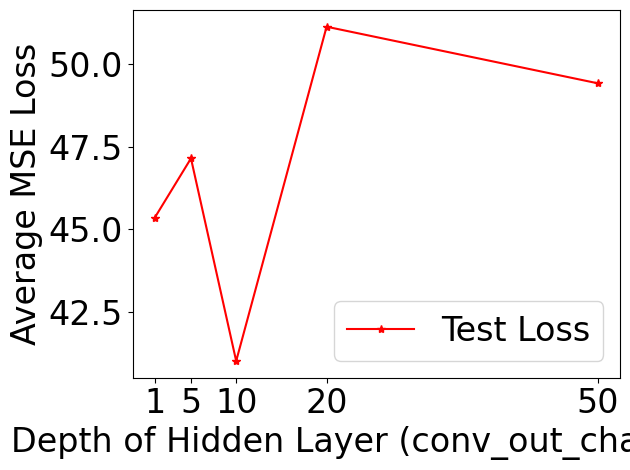

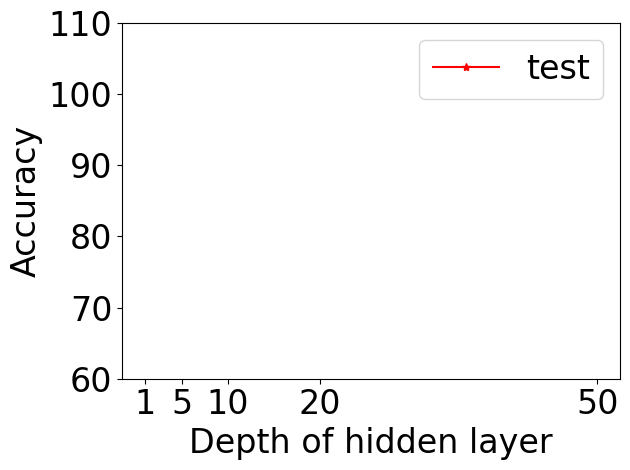

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot test loss for different conv_out_channels values.
plt.plot(N_array, test_array, 'r-*', label="Test Loss")
    
plt.xlabel('Depth of Hidden Layer (conv_out_channels)', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Average MSE Loss', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()


plt.plot(N_array, test_array, 'r-*', label="test")
plt.ylim(60,110)
plt.xlabel('Depth of hidden layer', fontsize=24)
plt.xticks(N_array)
plt.ylabel('Accuracy', fontsize=24)
plt.legend(loc='best', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
plt.tight_layout()
plt.show()

For conv_out_channels = 1:

During the 5 training epochs, the batch loss started at around 0.0273 and decreased to around 0.00457.
The test set’s average loss was about 0.0050 at the end of training.
These numbers tell you that with only 1 convolutional filter, the model still learns to reduce the MSE to around 0.005.
For conv_out_channels = 5:

Training started with a loss of about 0.01071 and dropped to around 0.00509 by epoch 5.
The test loss for this configuration was around 0.0053.
Notice that the training and test losses are fairly similar to the previous configuration; slight differences might be due to increased capacity.
For conv_out_channels = 10:

Here the training loss starts at roughly 0.01080 and decreases to around 0.00375.
The test loss goes as low as 0.0035.
This configuration seems to yield a lower test loss, which may indicate that with 10 filters, the model better captures the useful features from the sequence input.
For conv_out_channels = 20:

Training loss is initially a bit higher (around 0.03101) and then decreases to approximately 0.00402 by the final epoch.
The test loss is around 0.0055.
A slightly higher test loss compared to the 10-filter case might suggest that increasing the filter count further doesn’t necessarily improve performance—perhaps due to overfitting or because the extra capacity isn’t needed.
For conv_out_channels = 50:

The test losses recorded include a value of about 0.00549.
No training logs are shown here (other than the test losses), but you see the overall performance is recorded.
Critical losses:

Throughout, the "Critical losses" array remains empty. This indicates that you either did not define or pass in a critical dataset loader, so no evaluation on a “critical” dataset was performed.
What It Tells You
Training Progress:
The decreasing training loss over epochs shows that the model is learning on the training data.

Generalization:
The test losses, which are in a similar range (generally between ~0.0035 and ~0.0055), indicate that the model generalizes reasonably well on the test set for most configurations.

Impact of Convolutional Depth:
Changing the number of convolutional filters (conv_out_channels) affects the learning process. For example, a setting of 10 filters resulted in the lowest test loss (around 0.0035)

Epoch Logs:
Show batch training progress and loss reduction over epochs.

Test Loss:
Provides a measure of the model’s performance on unseen data, with lower MSE indicating better predictions.

Mean Squared Error: 49.4115
Mean Absolute Error: 4.7453
R² Score: -0.6105


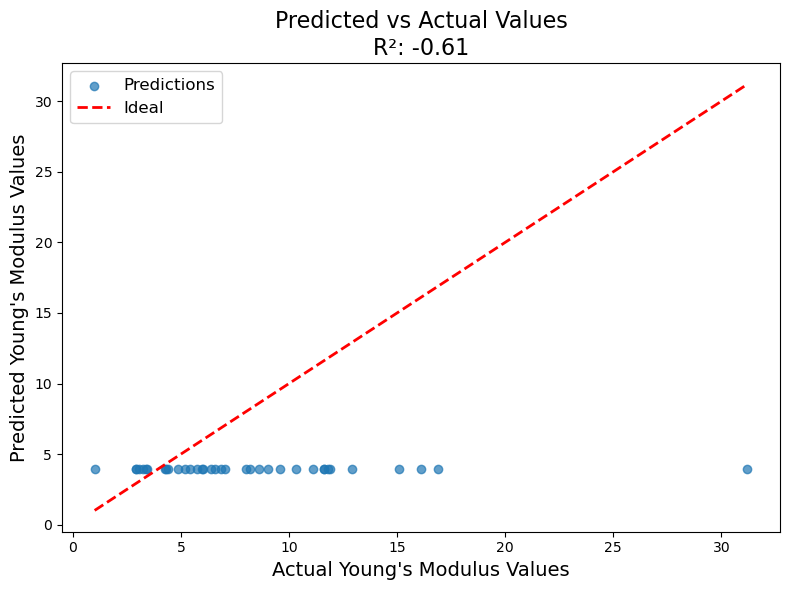

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Set the model to evaluation mode.
model.eval()

preds = []
actuals = []

# Iterate over the test data loader and collect predictions.
with torch.no_grad():
    for sample in test_loader:
        # Move tensors to CUDA if needed.
        if args.cuda:
            sample = {key: value.cuda() if isinstance(value, torch.Tensor) else value 
                      for key, value in sample.items()}
        output = model(sample)  # Output shape: (batch, 1)
        preds.append(output.cpu().numpy())
        actuals.append(sample['target'].cpu().numpy())

# Flatten the predictions and actual values into 1D arrays.
preds = np.concatenate(preds).flatten()
actuals = np.concatenate(actuals).flatten()

# Compute metrics.
mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)
r2 = r2_score(actuals, preds)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot of actual vs. predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(actuals, preds, alpha=0.7, label='Predictions')
# Plot an ideal line (y=x) for reference.
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], 'r--', lw=2, label='Ideal')
plt.xlabel("Actual Young's Modulus Values", fontsize=14)
plt.ylabel("Predicted Young's Modulus Values", fontsize=14)
plt.title(f"Predicted vs Actual Values\nR²: {r2:.2f}", fontsize=16)
plt.legend(loc="best", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
model.eval()

# dummy padded sequence and a mechanical input.
import torch
dummy_sequence = torch.randint(0, 21, (1, 200))  # Randomly generated padded sequence (1 sample, length 200)
dummy_mechanical_input = torch.tensor([[0.5]])     # Example auxiliary input value

sample = {
    'sequence': dummy_sequence,
    'mechanical_input': dummy_mechanical_input,
    # Note: target is not needed during inference.
}

with torch.no_grad():
    prediction = model(sample)
    # Print out which mechanical property is being predicted.
    print(f"Predicted {args.target_property}: {prediction.item()}")
    
    # Decode the sequence from numeric tokens to letters.
    # Remove padding tokens (zeros) from the sequence.
    seq_tokens = sample['sequence'][0]  # Taking the first (and only) sample.
    decoded_seq = "".join([polarity_to_aa.get(token.item(), '-') for token in seq_tokens if token.item() != 0])
    print("Input AA Sequence:", decoded_seq)

Predicted youngs_modulus: 3.9196178913116455
Input AA Sequence: IWRCPFHVVMPNNCFDEMPPDEHNVNCFYPVEYMELTRGKDIRQQSSPENEQPQFAHPRYTNTWTEFDHSTPATLHDIKCANSFQSLEPHKNFCTSHHKNQMYRNGVYWNIQIYAHWLIEIAFFWMDQLQKDVSACLYVFFCNQRANPCISDLWSSWDRPHTEDIRMSVQVMMDTMVFKNRHGA


In [11]:
import os
os.system("dot -V")
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"
print(os.environ["PATH"])

C:\Users\ameet\anaconda3\envs\spider;C:\Users\ameet\anaconda3\envs\spider\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\envs\spider\Library\usr\bin;C:\Users\ameet\anaconda3\envs\spider\Library\bin;C:\Users\ameet\anaconda3\envs\spider\Scripts;C:\Users\ameet\anaconda3\envs\spider\bin;C:\Users\ameet\anaconda3\condabin;C:\Users\ameet\anaconda3;C:\Users\ameet\anaconda3\Library\mingw-w64\bin;C:\Users\ameet\anaconda3\Library\usr\bin;C:\Users\ameet\anaconda3\Library\bin;C:\Users\ameet\anaconda3\Scripts;C:\Program Files\RevvitySignalsSoftware\ChemDrawApplications\ChemScript\Lib;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\MATLAB\R2023b\bin;C:\Program Files\Git\cmd;C:\Users\ameet\AppData\Local\Microsoft\WindowsApps;C:\Program Files\Graphviz\bin;.;C:\Program Files\Graphviz\bin


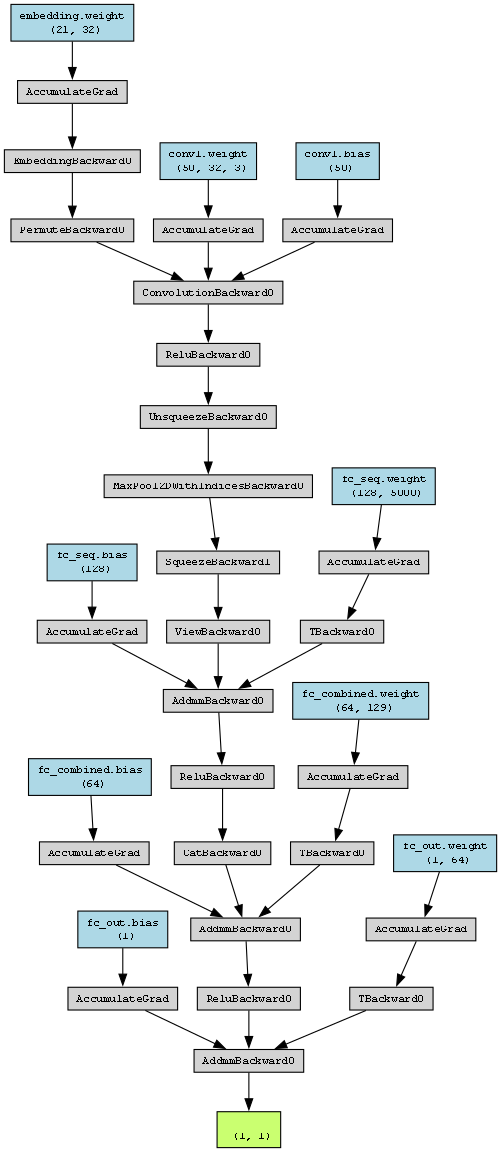

In [12]:
from torchviz import make_dot
import torch

# Create a dummy sample dictionary that matches your model input.
dummy_sample = {
    'sequence': torch.randint(0, 21, (1, 200)),  # One sample padded to length 200
    'mechanical_input': torch.tensor([[0.5]])     # Example auxiliary input
}

# Pass the dummy sample through the model.
output = model(dummy_sample)

# Visualize the computation graph.
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("cnn_model", format="png")  # 
from IPython.display import Image
Image("cnn_model.png")


Filter shape: (50, 32, 3)


C:\Users\ameet\AppData\Local\Temp\ipykernel_22844\3253493933.py:23: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


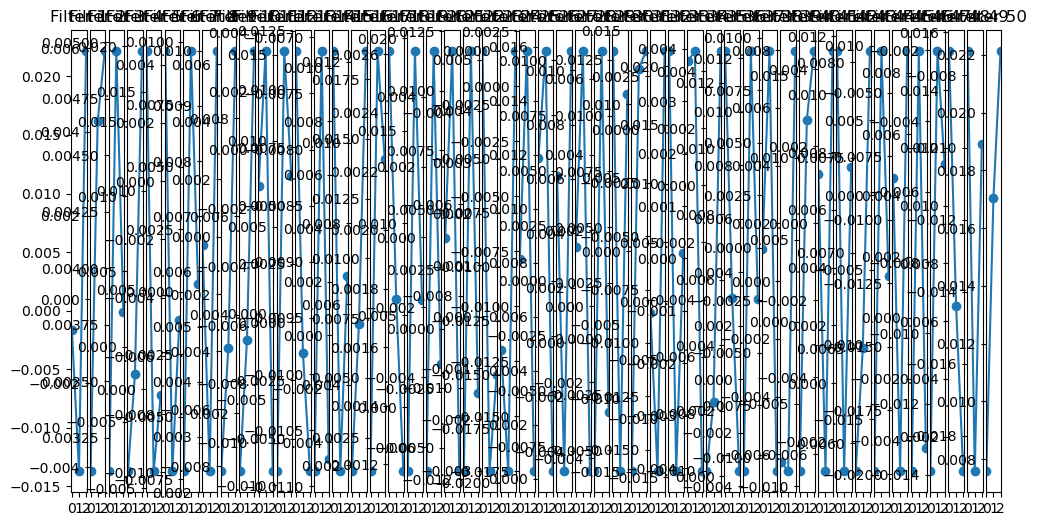

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Get the weights from your convolutional layer.
# For example, assuming your conv layer is model.conv1.
filters = model.conv1.weight.data.cpu().numpy()

# filters shape will be (conv_out_channels, in_channels, kernel_size)
conv_out_channels, in_channels, kernel_size = filters.shape
print("Filter shape:", filters.shape)

# Plot the filters.
plt.figure(figsize=(12, 6))
for i in range(conv_out_channels):
    plt.subplot(1, conv_out_channels, i + 1)
    # If in_channels is greater than 1, you might want to visualize each channel separately.
    # Here, we assume in_channels == embedding_dim (e.g., 32).
    # For simplicity, we average over channels.
    filter_avg = np.mean(filters[i], axis=0)
    plt.plot(filter_avg, marker='o')
    plt.title(f"Filter {i+1}")
    plt.xticks(range(kernel_size))
plt.tight_layout()
plt.show()


In [14]:
from torchsummary import summary
summary(model, input_data=[(1, 200), (1, 1)])  # Adjust based on input dimensions

TypeError: summary() got an unexpected keyword argument 'input_data'